In [23]:
import warnings
warnings.filterwarnings('ignore')

In [237]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV, 
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    AdaBoostRegressor,
    GradientBoostingRegressor,
)
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

import xgboost as xgb
from catboost import CatBoostRegressor
from interpret.glassbox import ExplainableBoostingRegressor
import numpy as np
import networkx as nx

In [119]:
data_path = 'ENB2012_data.xlsx'
data = pd.read_excel(data_path)
data.columns = [
    "Relative_Compactness","Surface_Area","Wall_Area","Roof_Area",
    "Overall_Height","Orientation","Glazing_Area",
    "Glazing_Area_Distribution","Heating_Load","Cooling_Load"
]

assert data.shape==(768,10), "Mismatch with UCI dataset."
assert data.isnull().sum().sum()==0, "Missing values!"

In [120]:
data.describe()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307195,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090204,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


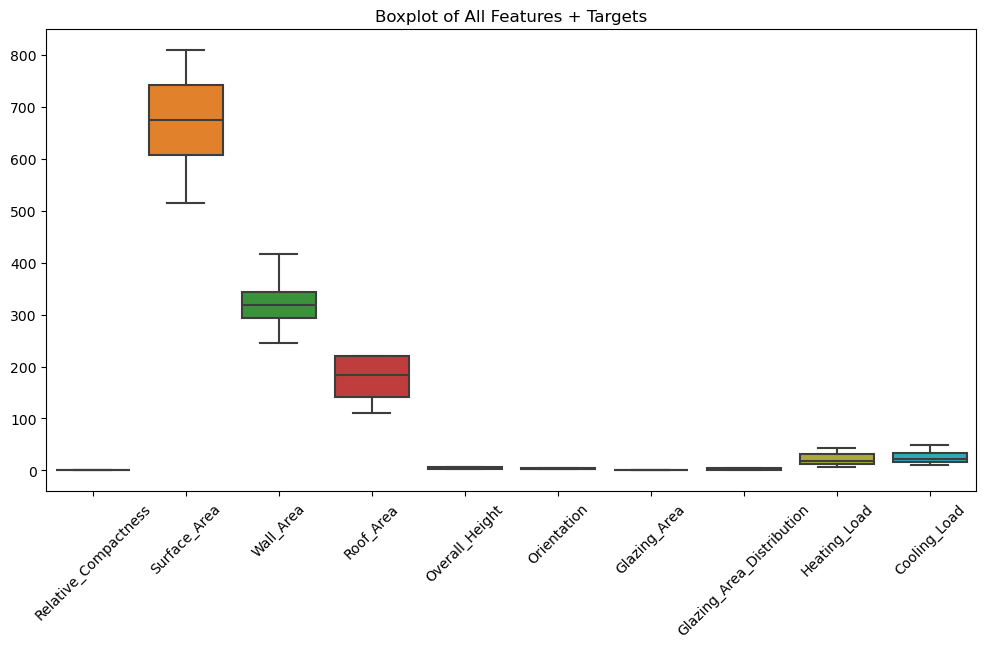

In [121]:
plt.figure(figsize=(12,6))
sns.boxplot(data=data)
plt.title("Boxplot of All Features + Targets")
plt.xticks(rotation=45)
plt.show()

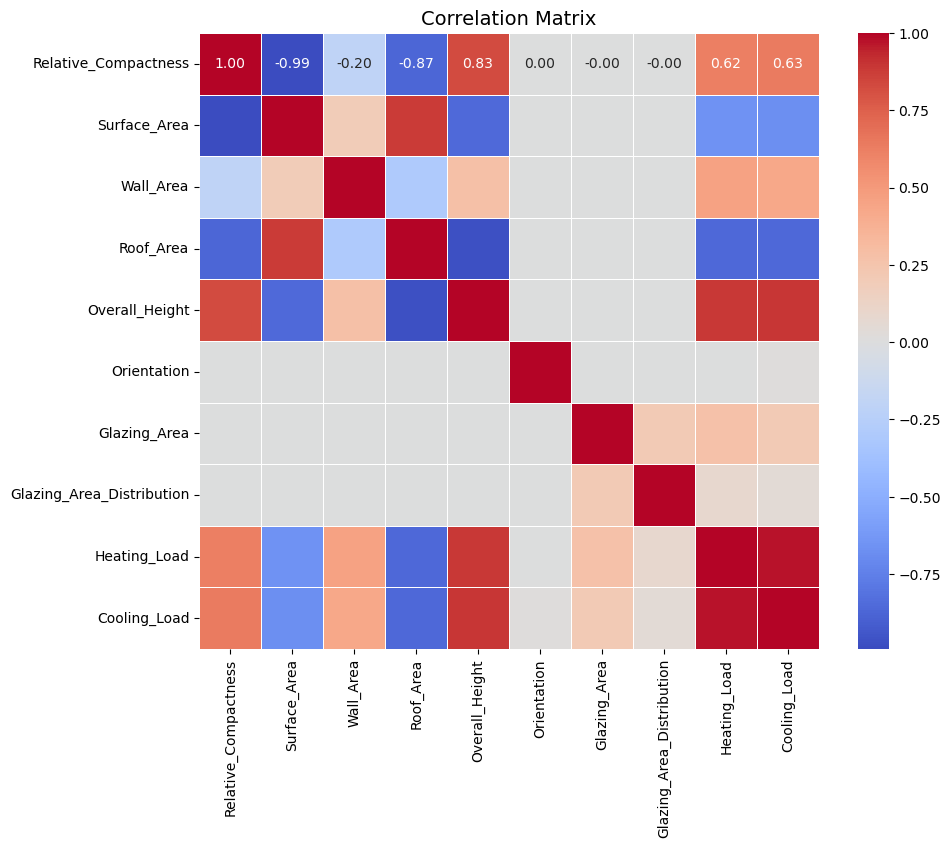

In [275]:
data = pd.read_excel(data_path, sheet_name=0)
data.columns = [
    "Relative_Compactness","Surface_Area","Wall_Area","Roof_Area",
    "Overall_Height","Orientation","Glazing_Area",
    "Glazing_Area_Distribution","Heating_Load","Cooling_Load"
]

data = data.apply(pd.to_numeric, errors='coerce')

plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix", fontsize=14)
plt.show()


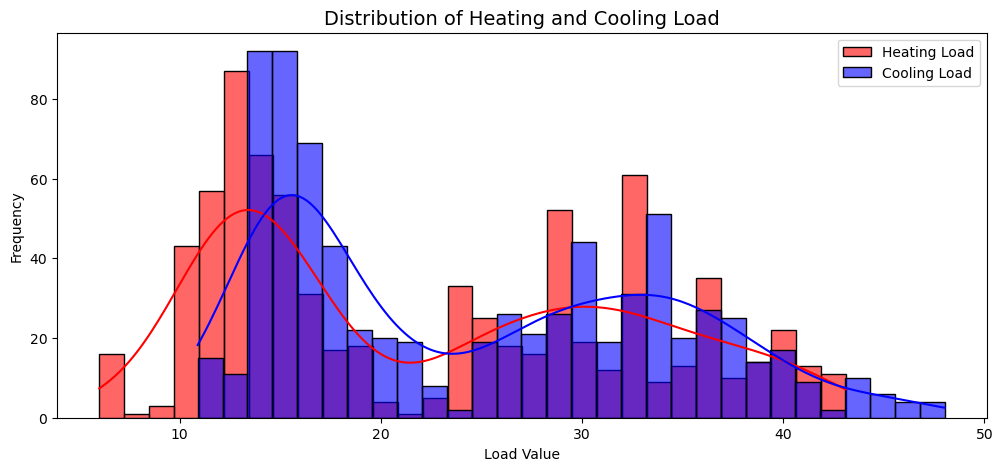

In [273]:
# Distribution of Heating and Cooling
plt.figure(figsize=(12, 5))
sns.histplot(data["Heating_Load"], kde=True, color="r", label="Heating Load", bins=30, alpha=0.6)
sns.histplot(data["Cooling_Load"], kde=True, color="b", label="Cooling Load", bins=30, alpha=0.6)
plt.legend()
plt.title("Distribution of Heating and Cooling Load", fontsize=14)
plt.xlabel("Load Value")
plt.ylabel("Frequency")
plt.show()

In [123]:
def remove_outliers_iqr(df, feature_cols, lower=0.25, upper=0.75, k=1.5):
    df_ = df.copy()
    for col in feature_cols:
        Q1 = df_[col].quantile(lower)
        Q3 = df_[col].quantile(upper)
        IQR = Q3-Q1
        lb = Q1 - k*IQR
        ub = Q3 + k*IQR
        df_ = df_[(df_[col]>=lb)&(df_[col]<=ub)]
    return df_

feat_cols = list(data.columns)
data_no_outliers = remove_outliers_iqr(data, feat_cols)

print("Original shape:", data.shape)
print("After removing outliers:", data_no_outliers.shape)

Original shape: (768, 10)
After removing outliers: (768, 10)


In [125]:
X = data_no_outliers.iloc[:,:-2]
y_heating = data_no_outliers["Heating_Load"]
y_cooling = data_no_outliers["Cooling_Load"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Heating
X_train_heat, X_test_heat, y_train_heat, y_test_heat = train_test_split(
    X_scaled, y_heating, test_size=0.2, random_state=42
)
# Cooling
X_train_cool, X_test_cool, y_train_cool, y_test_cool = train_test_split(
    X_scaled, y_cooling, test_size=0.2, random_state=42
)

print("Heating shapes:", X_train_heat.shape, X_test_heat.shape)
print("Cooling shapes:", X_train_cool.shape, X_test_cool.shape)

Heating shapes: (614, 8) (154, 8)
Cooling shapes: (614, 8) (154, 8)


In [127]:
def evaluate_model(model, X_tr, X_te, y_tr, y_te, target_name):
    model.fit(X_tr, y_tr)
    preds_ = model.predict(X_te)
    mse_ = mean_squared_error(y_te, preds_)
    rmse_ = sqrt(mse_)
    mae_ = mean_absolute_error(y_te, preds_)
    r2_ = r2_score(y_te, preds_)
    print(f"{target_name} => MSE={mse_:.4f}, RMSE={rmse_:.4f}, MAE={mae_:.4f}, R^2={r2_:.4f}")
    return {"Target":target_name, "MSE":mse_, "RMSE":rmse_, "MAE":mae_, "R^2":r2_}


In [128]:
print("FS for Heating_Load:")
fv_h, pv_h = f_regression(X, y_heating)
for i, col in enumerate(X.columns):
    print(f"{col}: F={fv_h[i]:.4f}, p={pv_h[i]:.6f}")

FS for Heating_Load:
Relative_Compactness: F=484.0456, p=0.000000
Surface_Area: F=585.2603, p=0.000000
Wall_Area: F=200.7279, p=0.000000
Roof_Area: F=2211.6203, p=0.000000
Overall_Height: F=2900.5902, p=0.000000
Orientation: F=0.0051, p=0.942944
Glazing_Area: F=60.1562, p=0.000000
Glazing_Area_Distribution: F=5.8920, p=0.015439


In [129]:
print("\nFS for Cooling_Load:")
fv_c, pv_c = f_regression(X, y_cooling)
for i, col in enumerate(X.columns):
    print(f"{col}: F={fv_c[i]:.4f}, p={pv_c[i]:.6f}")


FS for Cooling_Load:
Relative_Compactness: F=515.7639, p=0.000000
Surface_Area: F=634.1802, p=0.000000
Wall_Area: F=170.9216, p=0.000000
Roof_Area: F=2226.0314, p=0.000000
Overall_Height: F=3111.1278, p=0.000000
Orientation: F=0.1564, p=0.692562
Glazing_Area: F=34.4668, p=0.000000
Glazing_Area_Distribution: F=1.9604, p=0.161871


In [281]:
feature_importance_heating = pd.DataFrame({
    "Attribute": X.columns,
    "F-Score": fv_h,
}).sort_values(by="F-Score", ascending=False)

feature_importance_cooling = pd.DataFrame({
    "Attribute": X.columns,
    "F-Score": fv_c,
}).sort_values(by="F-Score", ascending=False)

In [279]:
feature_importance_heating

,Attribute,F-Score
4,Overall_Height,2900.590178
3,Roof_Area,2211.620312
1,Surface_Area,585.260349
0,Relative_Compactness,484.045616
2,Wall_Area,200.727893
6,Glazing_Area,60.156178
7,Glazing_Area_Distribution,5.892043
5,Orientation,0.005126


In [282]:
feature_importance_cooling

,Attribute,F-Score
4,Overall_Height,3111.127823
3,Roof_Area,2226.031391
1,Surface_Area,634.180214
0,Relative_Compactness,515.763924
2,Wall_Area,170.921606
6,Glazing_Area,34.466755
7,Glazing_Area_Distribution,1.960440
5,Orientation,0.156443


In [ ]:
X = data.drop(columns=["Heating_Load", "Cooling_Load"])
y_heating = data["Heating_Load"]
y_cooling = data["Cooling_Load"]

pearson_corr = data.corr(method="pearson")
spearman_corr = data.corr(method="spearman")

In [297]:
pearson_corr

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
Relative_Compactness,1.000000e+00,-9.919015e-01,-2.037817e-01,-8.688234e-01,8.277473e-01,4.678592e-17,-2.960552e-15,-7.107006e-16,0.622272,0.634339
Surface_Area,-9.919015e-01,1.000000e+00,1.955016e-01,8.807195e-01,-8.581477e-01,-3.459372e-17,3.636925e-15,2.438409e-15,-0.658120,-0.672999
Wall_Area,-2.037817e-01,1.955016e-01,1.000000e+00,-2.923165e-01,2.809757e-01,-2.429499e-17,-8.567455e-17,2.067384e-16,0.455671,0.427117
Roof_Area,-8.688234e-01,8.807195e-01,-2.923165e-01,1.000000e+00,-9.725122e-01,-5.830058e-17,-1.759011e-15,-1.078071e-15,-0.861828,-0.862547
Overall_Height,8.277473e-01,-8.581477e-01,2.809757e-01,-9.725122e-01,1.000000e+00,4.492205e-17,1.489134e-17,-2.920613e-17,0.889430,0.895785
Orientation,4.678592e-17,-3.459372e-17,-2.429499e-17,-5.830058e-17,4.492205e-17,1.000000e+00,-9.406007e-16,-2.549352e-16,-0.002587,0.014290
Glazing_Area,-2.960552e-15,3.636925e-15,-8.567455e-17,-1.759011e-15,1.489134e-17,-9.406007e-16,1.000000e+00,2.129642e-01,0.269842,0.207505
Glazing_Area_Distribution,-7.107006e-16,2.438409e-15,2.067384e-16,-1.078071e-15,-2.920613e-17,-2.549352e-16,2.129642e-01,1.000000e+00,0.087368,0.050525
Heating_Load,6.222719e-01,-6.581199e-01,4.556714e-01,-8.618281e-01,8.894305e-01,-2.586763e-03,2.698417e-01,8.736846e-02,1.000000,0.975862
Cooling_Load,6.343391e-01,-6.729989e-01,4.271170e-01,-8.625466e-01,8.957852e-01,1.428960e-02,2.075050e-01,5.052512e-02,0.975862,1.000000


In [298]:
spearman_corr

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
Relative_Compactness,1.000000,-1.000000,-0.255805,-0.870886,0.869048,0.000000,0.000000,0.000000,0.622135,0.651019
Surface_Area,-1.000000,1.000000,0.255805,0.870886,-0.869048,0.000000,0.000000,0.000000,-0.622135,-0.651019
Wall_Area,-0.255805,0.255805,1.000000,-0.193457,0.220763,0.000000,0.000000,0.000000,0.471458,0.415991
Roof_Area,-0.870886,0.870886,-0.193457,1.000000,-0.937043,0.000000,0.000000,0.000000,-0.804027,-0.803175
Overall_Height,0.869048,-0.869048,0.220763,-0.937043,1.000000,0.000000,0.000000,0.000000,0.861283,0.864876
Orientation,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-0.004168,0.017606
Glazing_Area,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.187592,0.322860,0.288904
Glazing_Area_Distribution,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.187592,1.000000,0.068343,0.046477
Heating_Load,0.622135,-0.622135,0.471458,-0.804027,0.861283,-0.004168,0.322860,0.068343,1.000000,0.972689
Cooling_Load,0.651019,-0.651019,0.415991,-0.803175,0.864876,0.017606,0.288904,0.046477,0.972689,1.000000


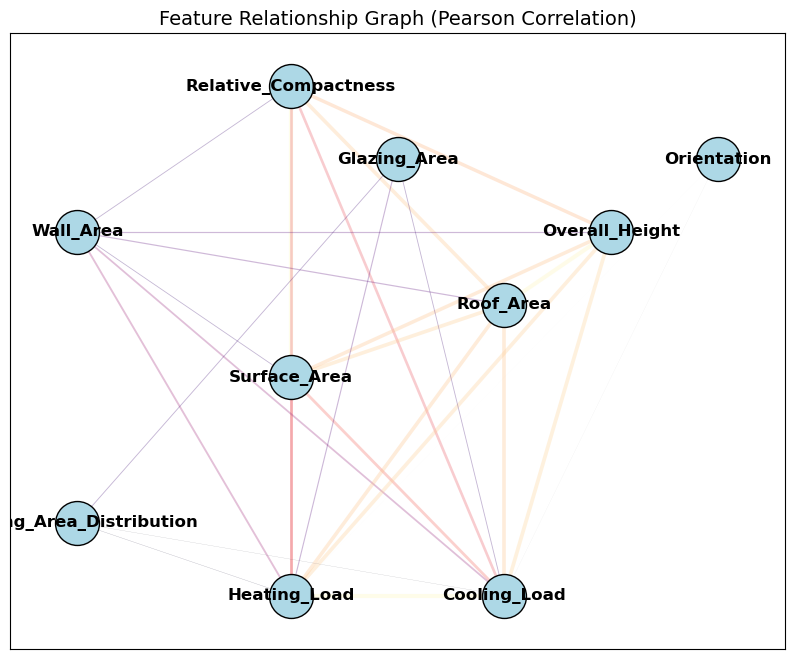

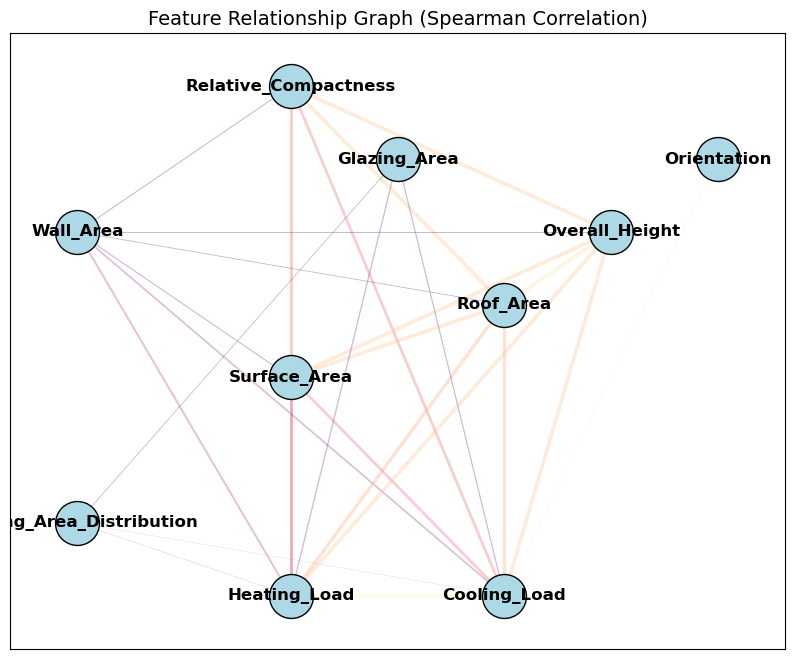

In [ ]:
node_pos = {
    "Wall_Area": (-1, 1),
    "Surface_Area": (0, 0),
    "Glazing_Area_Distribution": (-1, -1),
    "Heating_Load": (0, -1.5),
    "Cooling_Load": (1, -1.5),
    "Roof_Area": (1, 0.5),
    "Overall_Height": (1.5, 1),
    "Orientation": (2, 1.5),
    "Glazing_Area": (0.5, 1.5),
    "Relative_Compactness": (0, 2)
}

def create_graph(correlation_matrix, title):
    G = nx.Graph()

    nodes = list(X.columns) + ["Heating_Load", "Cooling_Load"]
    G.add_nodes_from(nodes)

    edges = []
    for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):  
            corr_value = correlation_matrix.loc[nodes[i], nodes[j]]
            edges.append((nodes[i], nodes[j], abs(corr_value)))

    G.add_weighted_edges_from(edges)

    plt.figure(figsize=(10, 8))
    edge_weights = [G[u][v]['weight'] * 3 for u, v in G.edges()]
    edge_colors = [G[u][v]['weight'] for u, v in G.edges()]

    nx.draw_networkx_nodes(G, node_pos, node_size=1000, node_color="lightblue", edgecolors="black")

    nx.draw_networkx_edges(G, node_pos, edgelist=G.edges(), width=edge_weights, alpha=0.3, edge_color=edge_colors, edge_cmap=plt.cm.magma)

    nx.draw_networkx_labels(G, node_pos, font_size=12, font_weight="bold")

    plt.title(title, fontsize=14)
    plt.show()

create_graph(pearson_corr, "Feature Relationship Graph (Pearson Correlation)")
create_graph(spearman_corr, "Feature Relationship Graph (Spearman Correlation)")

In [326]:
X = data.drop(columns=["Heating_Load", "Cooling_Load"])
y_heating = data["Heating_Load"]
y_cooling = data["Cooling_Load"]

f_scores_heating, _ = f_regression(X, y_heating)
f_scores_cooling, _ = f_regression(X, y_cooling)

In [327]:
f_scores_heating, f_scores_cooling

(array([4.84045616e+02, 5.85260349e+02, 2.00727893e+02, 2.21162031e+03,
        2.90059018e+03, 5.12560209e-03, 6.01561780e+01, 5.89204319e+00]),
 array([5.15763924e+02, 6.34180214e+02, 1.70921606e+02, 2.22603139e+03,
        3.11112782e+03, 1.56443475e-01, 3.44667548e+01, 1.96043991e+00]))

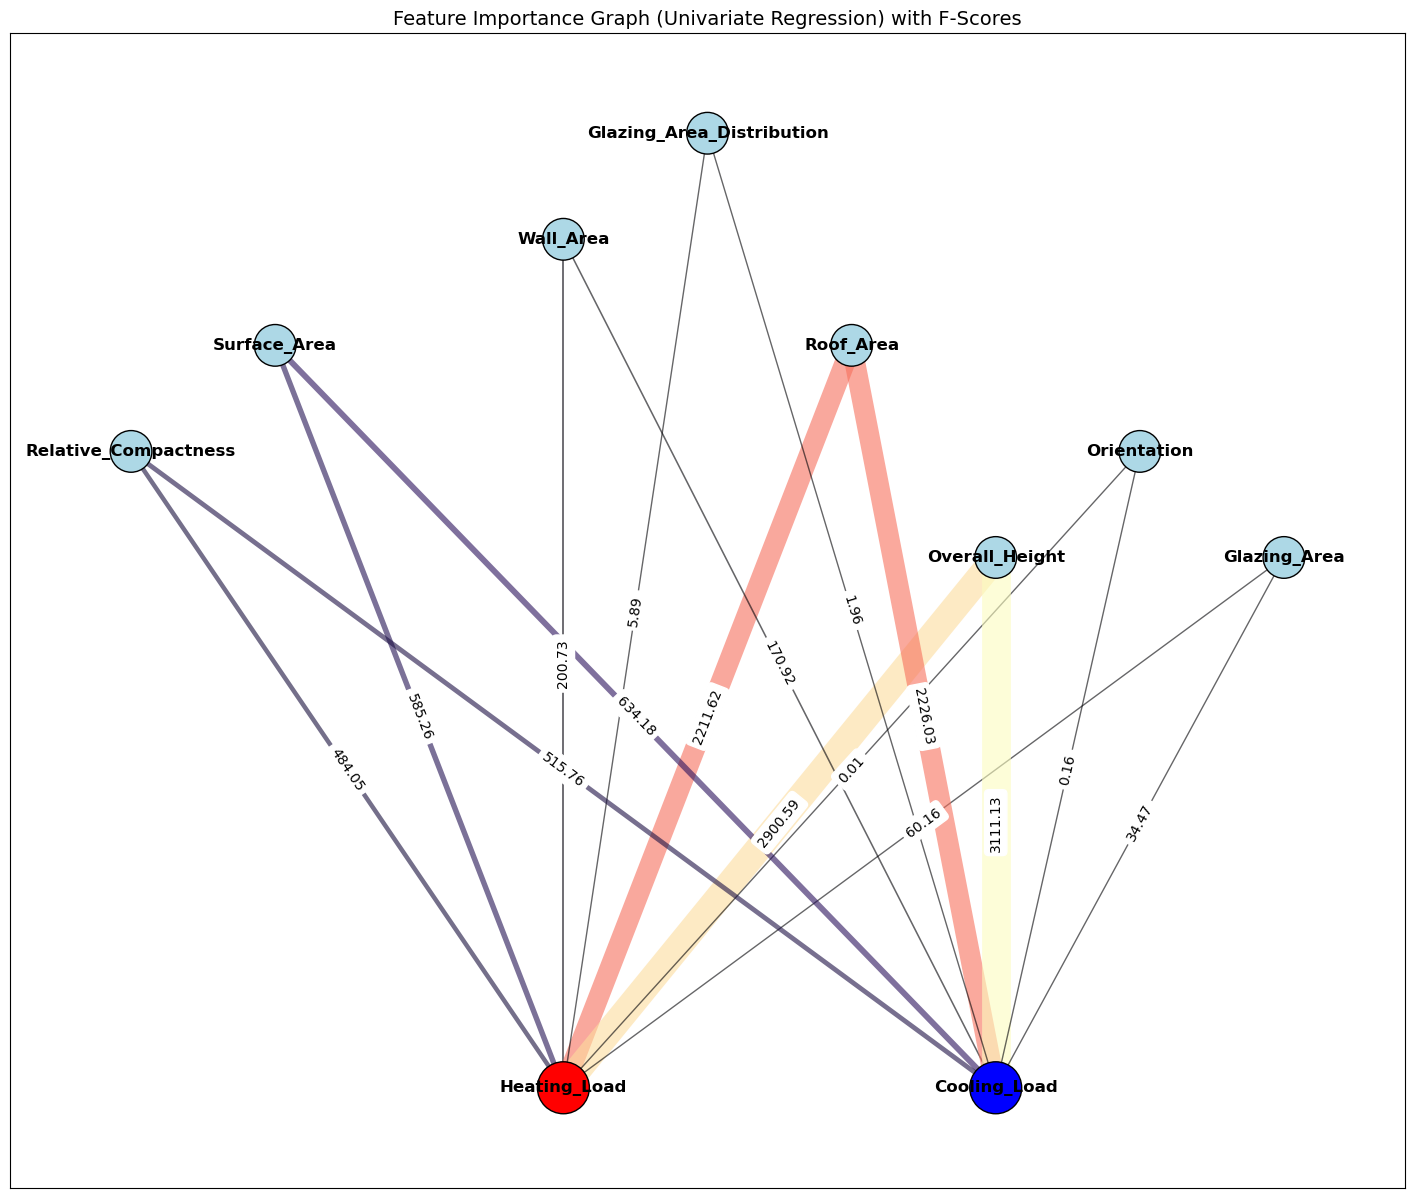

In [329]:
G = nx.Graph()

G.add_node("Heating_Load", color="red", size=1400)
G.add_node("Cooling_Load", color="blue", size=1400)

for feature in X.columns:
    G.add_node(feature, color="lightblue", size=900)

for i, feature in enumerate(X.columns):
    G.add_edge(feature, "Heating_Load", weight=f_scores_heating[i], label=f"{f_scores_heating[i]:.2f}")

for i, feature in enumerate(X.columns):
    G.add_edge(feature, "Cooling_Load", weight=f_scores_cooling[i], label=f"{f_scores_cooling[i]:.2f}")

node_pos = {
    "Heating_Load": (0, -1.5),
    "Cooling_Load": (1.5, -1.5),
    "Relative_Compactness": (-1.5, 1.5),
    "Surface_Area": (-1, 2),
    "Wall_Area": (0, 2.5),
    "Roof_Area": (1, 2),
    "Overall_Height": (1.5, 1),
    "Orientation": (2, 1.5),
    "Glazing_Area": (2.5, 1),
    "Glazing_Area_Distribution": (0.5, 3)
}

plt.figure(figsize=(18,15))

node_colors = [G.nodes[n]["color"] if "color" in G.nodes[n] else "lightblue" for n in G.nodes()]
node_sizes = [G.nodes[n]["size"] if "size" in G.nodes[n] else 900 for n in G.nodes()]
nx.draw_networkx_nodes(G, node_pos, node_size=node_sizes, node_color=node_colors, edgecolors="black")

edge_weights = [max(1, G[u][v]['weight'] / 150) for u, v in G.edges()]
edge_labels = {(u, v): G[u][v]['label'] for u, v in G.edges()}

nx.draw_networkx_edges(G, node_pos, edgelist=G.edges(), width=edge_weights, alpha=0.6, edge_color=edge_weights, edge_cmap=plt.cm.magma)

nx.draw_networkx_labels(G, node_pos, font_size=12, font_weight="bold")
nx.draw_networkx_edge_labels(G, node_pos, edge_labels=edge_labels, font_size=10)

plt.title("Feature Importance Graph (Univariate Regression) with F-Scores", fontsize=14)
plt.show()


In [330]:
f_score_df = pd.DataFrame({
    "Feature": X.columns,
    "F-Score (Heating_Load)": f_scores_heating,
    "F-Score (Cooling_Load)": f_scores_cooling
}).sort_values(by="F-Score (Heating_Load)", ascending=False)
f_score_df


,Feature,F-Score (Heating_Load),F-Score (Cooling_Load)
4,Overall_Height,2900.590178,3111.127823
3,Roof_Area,2211.620312,2226.031391
1,Surface_Area,585.260349,634.180214
0,Relative_Compactness,484.045616,515.763924
2,Wall_Area,200.727893,170.921606
6,Glazing_Area,60.156178,34.466755
7,Glazing_Area_Distribution,5.892043,1.960440
5,Orientation,0.005126,0.156443


In [130]:
k=5
sel_h = SelectKBest(score_func=f_regression, k=k)
sel_h.fit(X, y_heating)
mask_heat = sel_h.get_support()
X_heat_selected = X_scaled[:, mask_heat]

sel_c = SelectKBest(score_func=f_regression, k=k)
sel_c.fit(X, y_cooling)
mask_cool = sel_c.get_support()
X_cool_selected = X_scaled[:, mask_cool]

print("\nSelected Heating features:", X.columns[mask_heat].tolist())
print("Selected Cooling features:", X.columns[mask_cool].tolist())


Selected Heating features: ['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height']
Selected Cooling features: ['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height']


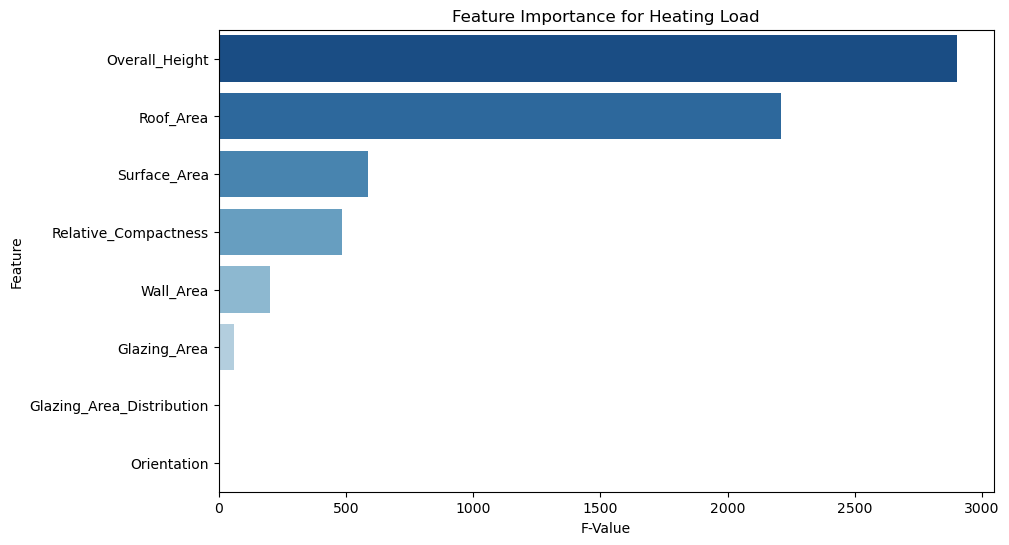

In [131]:
feature_importance_heating = pd.DataFrame({"Feature": X.columns, "F-Value": fv_h})
feature_importance_heating = feature_importance_heating.sort_values(by="F-Value", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance_heating["F-Value"], y=feature_importance_heating["Feature"], palette="Blues_r")
plt.title("Feature Importance for Heating Load")
plt.xlabel("F-Value")
plt.ylabel("Feature")
plt.show()

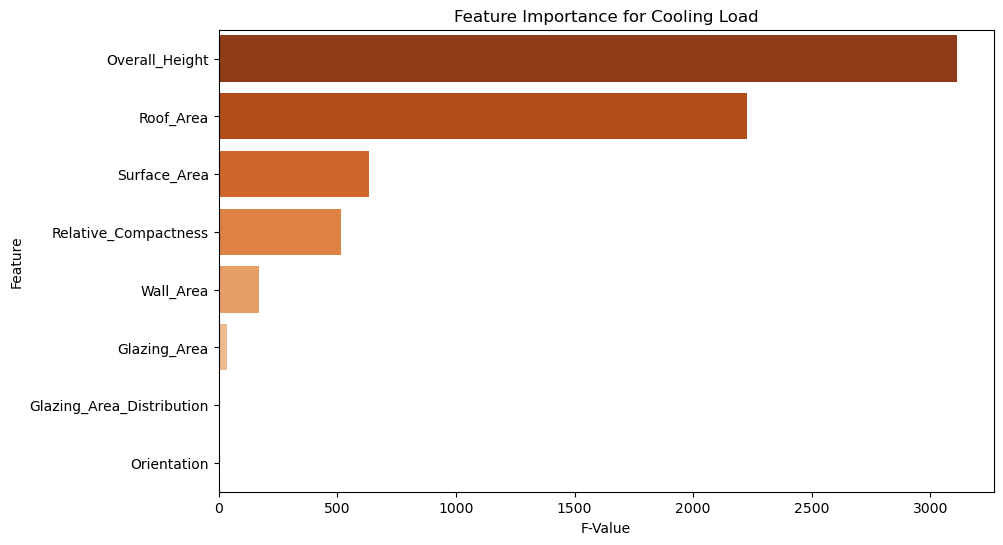

In [51]:
feature_importance_cooling = pd.DataFrame({"Feature": X.columns, "F-Value": fv_c})
feature_importance_cooling = feature_importance_cooling.sort_values(by="F-Value", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance_cooling["F-Value"], y=feature_importance_cooling["Feature"], palette="Oranges_r")
plt.title("Feature Importance for Cooling Load")
plt.xlabel("F-Value")
plt.ylabel("Feature")
plt.show()

In [135]:
X_train_heat_fs, X_test_heat_fs, y_train_heat_fs, y_test_heat_fs = train_test_split(
    X_heat_selected, y_heating, test_size=0.2, random_state=42
)
X_train_cool_fs, X_test_cool_fs, y_train_cool_fs, y_test_cool_fs = train_test_split(
    X_cool_selected, y_cooling, test_size=0.2, random_state=42
)

print("Heating FS ->", X_train_heat_fs.shape, X_test_heat_fs.shape)
print("Cooling FS ->", X_train_cool_fs.shape, X_test_cool_fs.shape)

all_results=[]

Heating FS -> (614, 5) (154, 5)
Cooling FS -> (614, 5) (154, 5)


In [ ]:
param_knn = {
    'n_neighbors':[3,5,7,9,11],
    'weights':['uniform','distance'],
    'p':[1,2, 3]
}

# Heating-NoFS
knn_h_no_fs_cv = GridSearchCV(
    KNeighborsRegressor(),
    param_knn,
    cv=5, scoring='neg_mean_absolute_error', n_jobs=-1
)
knn_h_no_fs_cv.fit(X_train_heat, y_train_heat)
best_knn_h_no_fs = knn_h_no_fs_cv.best_estimator_
res_knn_h_no_fs = evaluate_model(
    best_knn_h_no_fs,
    X_train_heat, X_test_heat,
    y_train_heat, y_test_heat,
    "KNN_Heating - NoFS"
)
all_results.append(res_knn_h_no_fs)

# Heating-FS
knn_h_fs_cv = GridSearchCV(
    KNeighborsRegressor(),
    param_knn,
    cv=5, scoring='neg_mean_absolute_error', n_jobs=-1
)
knn_h_fs_cv.fit(X_train_heat_fs, y_train_heat_fs)
best_knn_h_fs = knn_h_fs_cv.best_estimator_
res_knn_h_fs = evaluate_model(
    best_knn_h_fs,
    X_train_heat_fs, X_test_heat_fs,
    y_train_heat_fs, y_test_heat_fs,
    "KNN_Heating - FS"
)
all_results.append(res_knn_h_fs)

# Cooling-NoFS
knn_c_no_fs_cv = GridSearchCV(
    KNeighborsRegressor(),
    param_knn,
    cv=5, scoring='neg_mean_absolute_error', n_jobs=-1
)
knn_c_no_fs_cv.fit(X_train_cool, y_train_cool)
best_knn_c_no_fs = knn_c_no_fs_cv.best_estimator_
res_knn_c_no_fs = evaluate_model(
    best_knn_c_no_fs,
    X_train_cool, X_test_cool,
    y_train_cool, y_test_cool,
    "KNN_Cooling - NoFS"
)
all_results.append(res_knn_c_no_fs)

# Cooling-FS
knn_c_fs_cv = GridSearchCV(
    KNeighborsRegressor(),
    param_knn,
    cv=5, scoring='neg_mean_absolute_error', n_jobs=-1
)
knn_c_fs_cv.fit(X_train_cool_fs, y_train_cool_fs)
best_knn_c_fs = knn_c_fs_cv.best_estimator_

res_knn_c_fs = evaluate_model(
    best_knn_c_fs,
    X_train_cool_fs, X_test_cool_fs,
    y_train_cool_fs, y_test_cool_fs,
    "KNN_Cooling - FS"
)

print("-" * 40)
print(f"(NoFS, Heating): {knn_h_no_fs_cv.best_params_}")
print(f"(FS, Heating):   {knn_h_fs_cv.best_params_}")
print(f"(NoFS, Cooling): {knn_c_no_fs_cv.best_params_}")
print(f"(FS, Cooling):   {knn_c_fs_cv.best_params_}")
print("-" * 40)

all_results.append(res_knn_c_fs)

KNN_Heating - NoFS => MSE=1.3416, RMSE=1.1583, MAE=0.7980, R^2=0.9871
KNN_Heating - FS => MSE=9.9081, RMSE=3.1477, MAE=2.2611, R^2=0.9049
KNN_Cooling - NoFS => MSE=2.6996, RMSE=1.6431, MAE=1.1235, R^2=0.9709
KNN_Cooling - FS => MSE=7.8218, RMSE=2.7967, MAE=2.1065, R^2=0.9156
----------------------------------------
(NoFS, Heating): {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
(FS, Heating):   {'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}
(NoFS, Cooling): {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
(FS, Cooling):   {'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}
----------------------------------------


# Random Forest

In [140]:
param_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Heating-NoFS
rf_h_no_fs_cv = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_rf,
    cv=5, scoring='neg_mean_absolute_error', n_jobs=-1
)
rf_h_no_fs_cv.fit(X_train_heat, y_train_heat)
best_rf_h_no_fs = rf_h_no_fs_cv.best_estimator_
res_rf_h_no_fs = evaluate_model(
    best_rf_h_no_fs,
    X_train_heat, X_test_heat,
    y_train_heat, y_test_heat,
    "RF_Heating - NoFS"
)
all_results.append(res_rf_h_no_fs)

# Heating-FS
rf_h_fs_cv = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_rf,
    cv=5, scoring='neg_mean_absolute_error', n_jobs=-1
)
rf_h_fs_cv.fit(X_train_heat_fs, y_train_heat_fs)
best_rf_h_fs = rf_h_fs_cv.best_estimator_
res_rf_h_fs = evaluate_model(
    best_rf_h_fs,
    X_train_heat_fs, X_test_heat_fs,
    y_train_heat_fs, y_test_heat_fs,
    "RF_Heating - FS"
)
all_results.append(res_rf_h_fs)

# Cooling-NoFS
rf_c_no_fs_cv = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_rf,
    cv=5, scoring='neg_mean_absolute_error', n_jobs=-1
)
rf_c_no_fs_cv.fit(X_train_cool, y_train_cool)
best_rf_c_no_fs = rf_c_no_fs_cv.best_estimator_
res_rf_c_no_fs = evaluate_model(
    best_rf_c_no_fs,
    X_train_cool, X_test_cool,
    y_train_cool, y_test_cool,
    "RF_Cooling - NoFS"
)
all_results.append(res_rf_c_no_fs)

# Cooling-FS
rf_c_fs_cv = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_rf,
    cv=5, scoring='neg_mean_absolute_error', n_jobs=-1
)
rf_c_fs_cv.fit(X_train_cool_fs, y_train_cool_fs)
best_rf_c_fs = rf_c_fs_cv.best_estimator_
res_rf_c_fs = evaluate_model(
    best_rf_c_fs,
    X_train_cool_fs, X_test_cool_fs,
    y_train_cool_fs, y_test_cool_fs,
    "RF_Cooling - FS"
)

print("-" * 40)
print(f"(NoFS, Heating): {rf_h_no_fs_cv.best_params_}")
print(f"(FS, Heating):   {rf_h_fs_cv.best_params_}")
print(f"(NoFS, Cooling): {rf_c_no_fs_cv.best_params_}")
print(f"(FS, Cooling):   {rf_c_fs_cv.best_params_}")
print("-" * 40)

all_results.append(res_rf_c_fs)

RF_Heating - NoFS => {'Target': 'RF_Heating - NoFS', 'MSE': 0.24830318293957784, 'RMSE': 0.49830029393888364, 'MAE': 0.354371133546289, 'R^2': 0.9976177929240013}
RF_Heating - FS => {'Target': 'RF_Heating - FS', 'MSE': 9.316914984156117, 'RMSE': 3.0523621974064805, 'MAE': 2.215441595374452, 'R^2': 0.910614030239251}
RF_Cooling - NoFS => {'Target': 'RF_Cooling - NoFS', 'MSE': 2.7330254122799102, 'RMSE': 1.653186442080841, 'MAE': 1.0246363636363642, 'R^2': 0.9705039184742945}
RF_Cooling - FS => {'Target': 'RF_Cooling - FS', 'MSE': 7.602154538485634, 'RMSE': 2.757200489352494, 'MAE': 2.106078553950058, 'R^2': 0.917954012051748}
----------------------------------------
(NoFS, Heating): {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
(FS, Heating):   {'bootstrap': False, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
(NoFS, Cooling): {'bootstrap': Fa

# MLP

In [66]:
param_mlp = {
    'hidden_layer_sizes': [(50,50), (100,50)],
    'activation': ['relu','tanh'],
    'solver': ['adam','sgd'],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [300]
}

# Heating - NoFS
mlp_h_no_fs_cv = GridSearchCV(
    MLPRegressor(random_state=42),
    param_mlp,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
mlp_h_no_fs_cv.fit(X_train_heat, y_train_heat)
best_mlp_h_no_fs = mlp_h_no_fs_cv.best_estimator_
res_mlp_h_no_fs = evaluate_model(
    best_mlp_h_no_fs,
    X_train_heat, X_test_heat,
    y_train_heat, y_test_heat,
    "MLP_Heating - NoFS"
)
all_results.append(res_mlp_h_no_fs)

# Heating - FS
mlp_h_fs_cv = GridSearchCV(
    MLPRegressor(random_state=42),
    param_mlp,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
mlp_h_fs_cv.fit(X_train_heat_fs, y_train_heat_fs)
best_mlp_h_fs = mlp_h_fs_cv.best_estimator_
res_mlp_h_fs = evaluate_model(
    best_mlp_h_fs,
    X_train_heat_fs, X_test_heat_fs,
    y_train_heat_fs, y_test_heat_fs,
    "MLP_Heating - FS"
)
all_results.append(res_mlp_h_fs)

# Cooling - NoFS
mlp_c_no_fs_cv = GridSearchCV(
    MLPRegressor(random_state=42),
    param_mlp,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
mlp_c_no_fs_cv.fit(X_train_cool, y_train_cool)
best_mlp_c_no_fs = mlp_c_no_fs_cv.best_estimator_
res_mlp_c_no_fs = evaluate_model(
    best_mlp_c_no_fs,
    X_train_cool, X_test_cool,
    y_train_cool, y_test_cool,
    "MLP_Cooling - NoFS"
)
all_results.append(res_mlp_c_no_fs)

# Cooling - FS
mlp_c_fs_cv = GridSearchCV(
    MLPRegressor(random_state=42),
    param_mlp,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
mlp_c_fs_cv.fit(X_train_cool_fs, y_train_cool_fs)
best_mlp_c_fs = mlp_c_fs_cv.best_estimator_
res_mlp_c_fs = evaluate_model(
    best_mlp_c_fs,
    X_train_cool_fs, X_test_cool_fs,
    y_train_cool_fs, y_test_cool_fs,
    "MLP_Cooling - FS"
)

print("-" * 40)
print(f"(NoFS, Heating): {mlp_h_no_fs_cv.best_params_}")
print(f"(FS, Heating):   {mlp_h_fs_cv.best_params_}")
print(f"(NoFS, Cooling): {mlp_c_no_fs_cv.best_params_}")
print(f"(FS, Cooling):   {mlp_c_fs_cv.best_params_}")
print("-" * 40)

all_results.append(res_mlp_c_fs)

MLP_Heating - NoFS => MSE=0.2608, RMSE=0.5107, MAE=0.4002, R^2=0.9975
MLP_Heating - FS => MSE=9.5100, RMSE=3.0838, MAE=2.2436, R^2=0.9088
MLP_Cooling - NoFS => MSE=1.3785, RMSE=1.1741, MAE=0.8202, R^2=0.9851
MLP_Cooling - FS => MSE=9.4034, RMSE=3.0665, MAE=2.3991, R^2=0.8985
----------------------------------------
(NoFS, Heating): {'activation': 'tanh', 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.01, 'max_iter': 300, 'solver': 'sgd'}
(FS, Heating):   {'activation': 'tanh', 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.01, 'max_iter': 300, 'solver': 'sgd'}
(NoFS, Cooling): {'activation': 'tanh', 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.01, 'max_iter': 300, 'solver': 'sgd'}
(FS, Cooling):   {'activation': 'tanh', 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.01, 'max_iter': 300, 'solver': 'sgd'}
----------------------------------------


# AdaBoost

In [239]:
param_ada = {
    'n_estimators': [50, 100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],
    'base_estimator': [
        # Decision Trees
        DecisionTreeRegressor(max_depth=7),
        DecisionTreeRegressor(max_depth=10),
        DecisionTreeRegressor(max_depth=12, min_samples_split=5, min_samples_leaf=2),
        DecisionTreeRegressor(max_depth=15, min_samples_split=10, min_samples_leaf=4),
        
        # Gradient Boosting base estimator
        GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3),
        GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=5),

        # XGBoost base estimator
        xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3),
        xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5),
    ]
}


def evaluate_model(model, X_train, X_test, y_train, y_test, label):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    out = {"Target": label, "MSE": mse, "RMSE": rmse, "MAE": mae, "R^2": r2}
    print(label, "=>", out)
    return out

# Heating - NoFS
ada_h_no_fs_cv = GridSearchCV(
    AdaBoostRegressor(random_state=42),
    param_ada,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
ada_h_no_fs_cv.fit(X_train_heat, y_train_heat)
best_ada_h_no_fs = ada_h_no_fs_cv.best_estimator_
res_ada_h_no_fs = evaluate_model(
    best_ada_h_no_fs,
    X_train_heat, X_test_heat,
    y_train_heat, y_test_heat,
    "Ada_Heating - NoFS"
)
all_results.append(res_ada_h_no_fs)

# Heating - FS
ada_h_fs_cv = GridSearchCV(
    AdaBoostRegressor(random_state=42),
    param_ada,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
ada_h_fs_cv.fit(X_train_heat_fs, y_train_heat_fs)
best_ada_h_fs = ada_h_fs_cv.best_estimator_
res_ada_h_fs = evaluate_model(
    best_ada_h_fs,
    X_train_heat_fs, X_test_heat_fs,
    y_train_heat_fs, y_test_heat_fs,
    "Ada_Heating - FS"
)
all_results.append(res_ada_h_fs)

# Cooling - NoFS
ada_c_no_fs_cv = GridSearchCV(
    AdaBoostRegressor(random_state=42),
    param_ada,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
ada_c_no_fs_cv.fit(X_train_cool, y_train_cool)
best_ada_c_no_fs = ada_c_no_fs_cv.best_estimator_
res_ada_c_no_fs = evaluate_model(
    best_ada_c_no_fs,
    X_train_cool, X_test_cool,
    y_train_cool, y_test_cool,
    "Ada_Cooling - NoFS"
)
all_results.append(res_ada_c_no_fs)

# Cooling - FS
ada_c_fs_cv = GridSearchCV(
    AdaBoostRegressor(random_state=42),
    param_ada,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
ada_c_fs_cv.fit(X_train_cool_fs, y_train_cool_fs)
best_ada_c_fs = ada_c_fs_cv.best_estimator_
res_ada_c_fs = evaluate_model(
    best_ada_c_fs,
    X_train_cool_fs, X_test_cool_fs,
    y_train_cool_fs, y_test_cool_fs,
    "Ada_Cooling - FS"
)

print("-" * 40)
print(f"(NoFS, Heating): {ada_h_no_fs_cv.best_params_}")
print(f"(FS, Heating):   {ada_h_fs_cv.best_params_}")
print(f"(NoFS, Cooling): {ada_c_no_fs_cv.best_params_}")
print(f"(FS, Cooling):   {ada_c_fs_cv.best_params_}")
print("-" * 40)

all_results.append(res_ada_c_fs)

Ada_Heating - NoFS => {'Target': 'Ada_Heating - NoFS', 'MSE': 0.186415447328686, 'RMSE': 0.43175855211991576, 'MAE': 0.3118599991656306, 'R^2': 0.998211540454518}
Ada_Heating - FS => {'Target': 'Ada_Heating - FS', 'MSE': 9.297855015211884, 'RMSE': 3.049238432004274, 'MAE': 2.222323706914854, 'R^2': 0.9107968905326622}
Ada_Cooling - NoFS => {'Target': 'Ada_Cooling - NoFS', 'MSE': 0.986780060683511, 'RMSE': 0.9933680388876577, 'MAE': 0.6788438742384241, 'R^2': 0.9893502105808885}
Ada_Cooling - FS => {'Target': 'Ada_Cooling - FS', 'MSE': 7.597816906422448, 'RMSE': 2.756413776344627, 'MAE': 2.117481359073549, 'R^2': 0.9180008257946387}
----------------------------------------
(NoFS, Heating): {'base_estimator': GradientBoostingRegressor(learning_rate=0.05, max_depth=5, n_estimators=200), 'learning_rate': 0.2, 'n_estimators': 100}
(FS, Heating):   {'base_estimator': GradientBoostingRegressor(), 'learning_rate': 0.01, 'n_estimators': 50}
(NoFS, Cooling): {'base_estimator': GradientBoostingRe

In [331]:
best_base_estimator = GradientBoostingRegressor(
    n_estimators=300, learning_rate=0.1, max_depth=6, 
    min_samples_split=5, min_samples_leaf=2, random_state=42
)

optimized_ada = AdaBoostRegressor(
    base_estimator=best_base_estimator,
    n_estimators=200,
    learning_rate=0.1,
    random_state=42
)

optimized_ada.fit(X_train_heat, y_train_heat)

y_pred = optimized_ada.predict(X_test_heat)

mse = mean_squared_error(y_test_heat, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_heat, y_pred)
r2 = r2_score(y_test_heat, y_pred)

print("Optimized Ada_Heating - NoFS Results:")
print(f"MSE: {mse:.6f}, RMSE: {rmse:.6f}, MAE: {mae:.6f}, R²: {r2:.6f}")

Optimized Ada_Heating - NoFS Results:
MSE: 0.184430, RMSE: 0.429453, MAE: 0.279111, R²: 0.998231


In [334]:
res_optimized_ada_h_no_fs = {
    "Target": "Ada_Heating - NoFS",
    "MSE": mse,
    "RMSE": rmse,
    "MAE": mae,
    "R^2": r2
}

all_results.append(res_optimized_ada_h_no_fs)

# GradientBoosting

In [68]:
param_gb = {
    'n_estimators': [50,100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3,5]
}

# Heating - NoFS
gb_h_no_fs_cv = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_gb,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
gb_h_no_fs_cv.fit(X_train_heat, y_train_heat)
best_gb_h_no_fs = gb_h_no_fs_cv.best_estimator_
res_gb_h_no_fs = evaluate_model(
    best_gb_h_no_fs,
    X_train_heat, X_test_heat,
    y_train_heat, y_test_heat,
    "GB_Heating - NoFS"
)
all_results.append(res_gb_h_no_fs)

# Heating - FS
gb_h_fs_cv = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_gb,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
gb_h_fs_cv.fit(X_train_heat_fs, y_train_heat_fs)
best_gb_h_fs = gb_h_fs_cv.best_estimator_
res_gb_h_fs = evaluate_model(
    best_gb_h_fs,
    X_train_heat_fs, X_test_heat_fs,
    y_train_heat_fs, y_test_heat_fs,
    "GB_Heating - FS"
)
all_results.append(res_gb_h_fs)

# Cooling - NoFS
gb_c_no_fs_cv = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_gb,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
gb_c_no_fs_cv.fit(X_train_cool, y_train_cool)
best_gb_c_no_fs = gb_c_no_fs_cv.best_estimator_
res_gb_c_no_fs = evaluate_model(
    best_gb_c_no_fs,
    X_train_cool, X_test_cool,
    y_train_cool, y_test_cool,
    "GB_Cooling - NoFS"
)
all_results.append(res_gb_c_no_fs)

# Cooling - FS
gb_c_fs_cv = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_gb,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
gb_c_fs_cv.fit(X_train_cool_fs, y_train_cool_fs)
best_gb_c_fs = gb_c_fs_cv.best_estimator_
res_gb_c_fs = evaluate_model(
    best_gb_c_fs,
    X_train_cool_fs, X_test_cool_fs,
    y_train_cool_fs, y_test_cool_fs,
    "GB_Cooling - FS"
)

print("-" * 40)
print(f"(NoFS, Heating): {gb_h_no_fs_cv.best_params_}")
print(f"(FS, Heating):   {gb_h_fs_cv.best_params_}")
print(f"(NoFS, Cooling): {gb_c_no_fs_cv.best_params_}")
print(f"(FS, Cooling):   {gb_c_fs_cv.best_params_}")
print("-" * 40)

all_results.append(res_gb_c_fs)

GB_Heating - NoFS => MSE=0.2101, RMSE=0.4584, MAE=0.3238, R^2=0.9980
GB_Heating - FS => MSE=9.3169, RMSE=3.0524, MAE=2.2154, R^2=0.9106
GB_Cooling - NoFS => MSE=1.1861, RMSE=1.0891, MAE=0.6926, R^2=0.9872
GB_Cooling - FS => MSE=7.5328, RMSE=2.7446, MAE=2.1022, R^2=0.9187
----------------------------------------
(NoFS, Heating): {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
(FS, Heating):   {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
(NoFS, Cooling): {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
(FS, Cooling):   {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
----------------------------------------


# XGBoost

In [196]:
param_xgb = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 6, 8, 7, 10],
    'learning_rate': [0.001, 0.005, 0.01, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 1, 10]
}

# Heating - NoFS
xgb_h_no_fs_cv = GridSearchCV(
    xgb.XGBRegressor(random_state=42),
    param_xgb,
    cv=5, 
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
xgb_h_no_fs_cv.fit(X_train_heat, y_train_heat)
best_xgb_h_no_fs = xgb_h_no_fs_cv.best_estimator_
res_xgb_h_no_fs = evaluate_model(
    best_xgb_h_no_fs,
    X_train_heat, X_test_heat,
    y_train_heat, y_test_heat,
    "XGB_Heating - NoFS"
)
all_results.append(res_xgb_h_no_fs)

# Heating - FS
xgb_h_fs_cv = GridSearchCV(
    xgb.XGBRegressor(random_state=42),
    param_xgb,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
xgb_h_fs_cv.fit(X_train_heat_fs, y_train_heat_fs)
best_xgb_h_fs = xgb_h_fs_cv.best_estimator_
res_xgb_h_fs = evaluate_model(
    best_xgb_h_fs,
    X_train_heat_fs, X_test_heat_fs,
    y_train_heat_fs, y_test_heat_fs,
    "XGB_Heating - FS"
)
all_results.append(res_xgb_h_fs)

# Cooling - NoFS
xgb_c_no_fs_cv = GridSearchCV(
    xgb.XGBRegressor(random_state=42),
    param_xgb,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
xgb_c_no_fs_cv.fit(X_train_cool, y_train_cool)
best_xgb_c_no_fs = xgb_c_no_fs_cv.best_estimator_
res_xgb_c_no_fs = evaluate_model(
    best_xgb_c_no_fs,
    X_train_cool, X_test_cool,
    y_train_cool, y_test_cool,
    "XGB_Cooling - NoFS"
)
all_results.append(res_xgb_c_no_fs)

# Cooling - FS
xgb_c_fs_cv = GridSearchCV(
    xgb.XGBRegressor(random_state=42),
    param_xgb,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
xgb_c_fs_cv.fit(X_train_cool_fs, y_train_cool_fs)
best_xgb_c_fs = xgb_c_fs_cv.best_estimator_
res_xgb_c_fs = evaluate_model(
    best_xgb_c_fs,
    X_train_cool_fs, X_test_cool_fs,
    y_train_cool_fs, y_test_cool_fs,
    "XGB_Cooling - FS"
)

print("-" * 40)
print(f"(NoFS, Heating): {xgb_h_no_fs_cv.best_params_}")
print(f"(FS, Heating):   {xgb_h_fs_cv.best_params_}")
print(f"(NoFS, Cooling): {xgb_c_no_fs_cv.best_params_}")
print(f"(FS, Cooling):   {xgb_c_fs_cv.best_params_}")
print("-" * 40)

all_results.append(res_xgb_c_fs)

XGB_Heating - NoFS => {'Target': 'XGB_Heating - NoFS', 'MSE': 0.1487412459072847, 'RMSE': 0.38566986647557094, 'MAE': 0.2589378599439347, 'R^2': 0.9985729846701988}
XGB_Heating - FS => {'Target': 'XGB_Heating - FS', 'MSE': 9.314592150034509, 'RMSE': 3.0519816759008416, 'MAE': 2.2202805716279266, 'R^2': 0.9106363153820163}
XGB_Cooling - NoFS => {'Target': 'XGB_Cooling - NoFS', 'MSE': 0.8043916417809286, 'RMSE': 0.8968788333888411, 'MAE': 0.47445756392045446, 'R^2': 0.9913186312362996}
XGB_Cooling - FS => {'Target': 'XGB_Cooling - FS', 'MSE': 7.531104671215974, 'RMSE': 2.7442858217058905, 'MAE': 2.102153011668812, 'R^2': 0.9187208152684178}
----------------------------------------
(NoFS, Heating): {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.8}
(FS, Heating):   {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda':

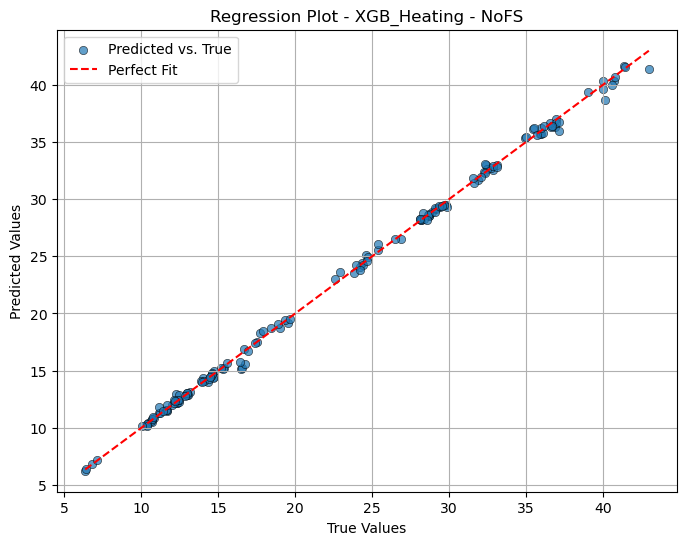

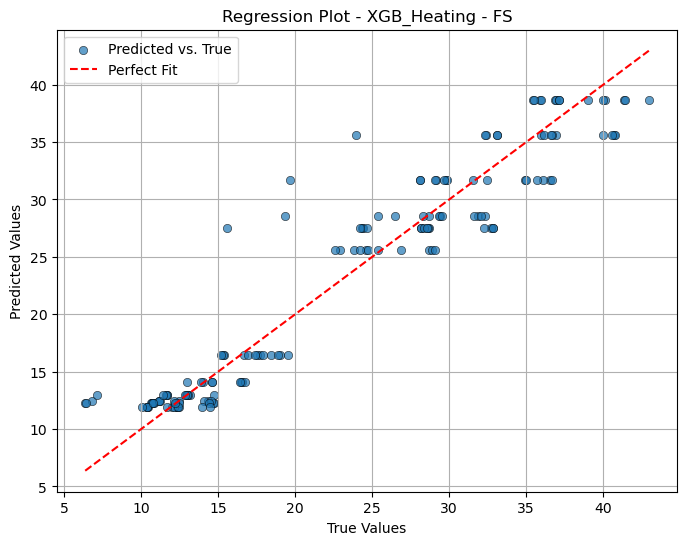

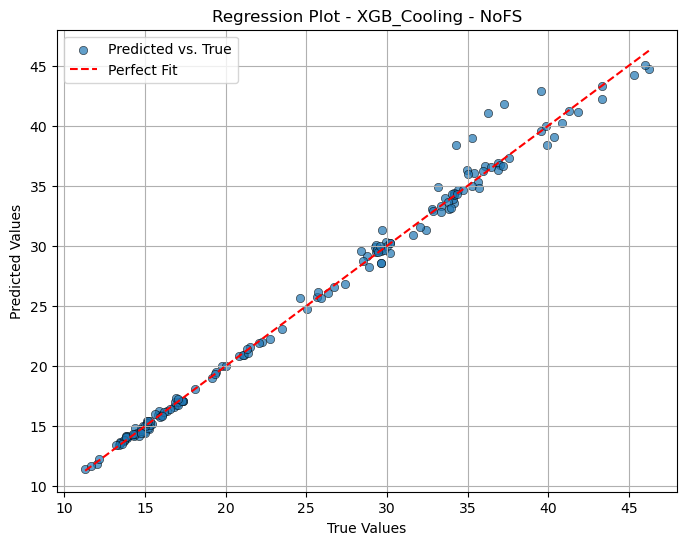

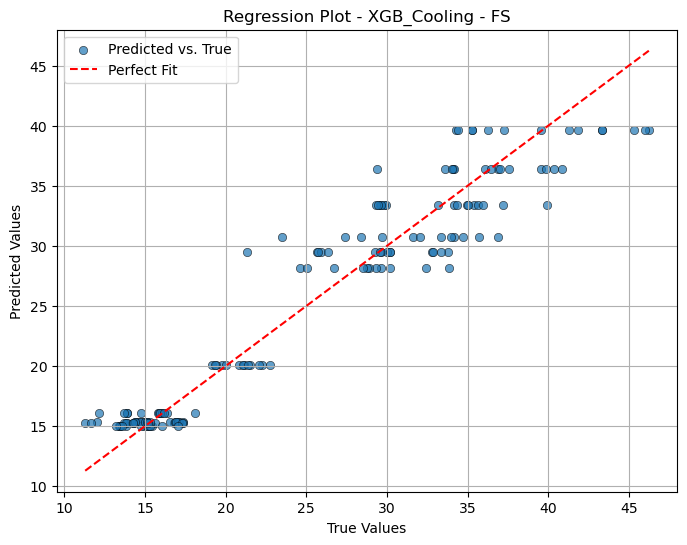

In [349]:
def plot_regression_results(y_true, y_pred, label):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.7, edgecolor="k", label="Predicted vs. True")
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color="red", linestyle="--", label="Perfect Fit")
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Regression Plot - {label}")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_regression_results(y_test_heat, best_xgb_h_no_fs.predict(X_test_heat), "XGB_Heating - NoFS")
plot_regression_results(y_test_heat_fs, best_xgb_h_fs.predict(X_test_heat_fs), "XGB_Heating - FS")
plot_regression_results(y_test_cool, best_xgb_c_no_fs.predict(X_test_cool), "XGB_Cooling - NoFS")
plot_regression_results(y_test_cool_fs, best_xgb_c_fs.predict(X_test_cool_fs), "XGB_Cooling - FS")


# CatBoost

In [71]:
param_cat = {
    'iterations':[50,100],
    'learning_rate':[0.01,0.1],
    'depth':[4,6]
}

# Heating - NoFS
cat_h_no_fs_cv = GridSearchCV(
    CatBoostRegressor(random_seed=42, verbose=0),
    param_cat,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
cat_h_no_fs_cv.fit(X_train_heat, y_train_heat)
best_cat_h_no_fs = cat_h_no_fs_cv.best_estimator_
res_cat_h_no_fs = evaluate_model(
    best_cat_h_no_fs,
    X_train_heat, X_test_heat,
    y_train_heat, y_test_heat,
    "CatBoost_Heating - NoFS"
)
all_results.append(res_cat_h_no_fs)

# Heating - FS
cat_h_fs_cv = GridSearchCV(
    CatBoostRegressor(random_seed=42, verbose=0),
    param_cat,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
cat_h_fs_cv.fit(X_train_heat_fs, y_train_heat_fs)
best_cat_h_fs = cat_h_fs_cv.best_estimator_
res_cat_h_fs = evaluate_model(
    best_cat_h_fs,
    X_train_heat_fs, X_test_heat_fs,
    y_train_heat_fs, y_test_heat_fs,
    "CatBoost_Heating - FS"
)
all_results.append(res_cat_h_fs)

# Cooling - NoFS
cat_c_no_fs_cv = GridSearchCV(
    CatBoostRegressor(random_seed=42, verbose=0),
    param_cat,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
cat_c_no_fs_cv.fit(X_train_cool, y_train_cool)
best_cat_c_no_fs = cat_c_no_fs_cv.best_estimator_
res_cat_c_no_fs = evaluate_model(
    best_cat_c_no_fs,
    X_train_cool, X_test_cool,
    y_train_cool, y_test_cool,
    "CatBoost_Cooling - NoFS"
)
all_results.append(res_cat_c_no_fs)

# Cooling - FS
cat_c_fs_cv = GridSearchCV(
    CatBoostRegressor(random_seed=42, verbose=0),
    param_cat,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
cat_c_fs_cv.fit(X_train_cool_fs, y_train_cool_fs)
best_cat_c_fs = cat_c_fs_cv.best_estimator_
res_cat_c_fs = evaluate_model(
    best_cat_c_fs,
    X_train_cool_fs, X_test_cool_fs,
    y_train_cool_fs, y_test_cool_fs,
    "CatBoost_Cooling - FS"
)

print("-" * 40)
print(f"(NoFS, Heating): {cat_h_no_fs_cv.best_params_}")
print(f"(FS, Heating):   {cat_h_fs_cv.best_params_}")
print(f"(NoFS, Cooling): {cat_c_no_fs_cv.best_params_}")
print(f"(FS, Cooling):   {cat_c_fs_cv.best_params_}")
print("-" * 40)

all_results.append(res_cat_c_fs)

CatBoost_Heating - NoFS => MSE=0.1904, RMSE=0.4363, MAE=0.3255, R^2=0.9982
CatBoost_Heating - FS => MSE=9.3174, RMSE=3.0524, MAE=2.2163, R^2=0.9106
CatBoost_Cooling - NoFS => MSE=1.1967, RMSE=1.0939, MAE=0.7260, R^2=0.9871
CatBoost_Cooling - FS => MSE=7.5800, RMSE=2.7532, MAE=2.1029, R^2=0.9182
----------------------------------------
(NoFS, Heating): {'depth': 6, 'iterations': 100, 'learning_rate': 0.1}
(FS, Heating):   {'depth': 6, 'iterations': 100, 'learning_rate': 0.1}
(NoFS, Cooling): {'depth': 6, 'iterations': 100, 'learning_rate': 0.1}
(FS, Cooling):   {'depth': 4, 'iterations': 100, 'learning_rate': 0.1}
----------------------------------------


# EBM

In [ ]:
param_ebm = {
    'max_rounds':[100,200],
    'max_leaves':[3,5],
    'learning_rate':[0.01,0.1]
}

# Heating - NoFS
ebm_h_no_fs_cv = GridSearchCV(
    ExplainableBoostingRegressor(random_state=42),
    param_ebm,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
ebm_h_no_fs_cv.fit(X_train_heat, y_train_heat)
best_ebm_h_no_fs = ebm_h_no_fs_cv.best_estimator_
res_ebm_h_no_fs = evaluate_model(
    best_ebm_h_no_fs,
    X_train_heat, X_test_heat,
    y_train_heat, y_test_heat,
    "EBM_Heating - NoFS"
)
all_results.append(res_ebm_h_no_fs)

# Heating - FS
ebm_h_fs_cv = GridSearchCV(
    ExplainableBoostingRegressor(random_state=42),
    param_ebm,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
ebm_h_fs_cv.fit(X_train_heat_fs, y_train_heat_fs)
best_ebm_h_fs = ebm_h_fs_cv.best_estimator_
res_ebm_h_fs = evaluate_model(
    best_ebm_h_fs,
    X_train_heat_fs, X_test_heat_fs,
    y_train_heat_fs, y_test_heat_fs,
    "EBM_Heating - FS"
)
all_results.append(res_ebm_h_fs)

# Cooling - NoFS
ebm_c_no_fs_cv = GridSearchCV(
    ExplainableBoostingRegressor(random_state=42),
    param_ebm,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
ebm_c_no_fs_cv.fit(X_train_cool, y_train_cool)
best_ebm_c_no_fs = ebm_c_no_fs_cv.best_estimator_
res_ebm_c_no_fs = evaluate_model(
    best_ebm_c_no_fs,
    X_train_cool, X_test_cool,
    y_train_cool, y_test_cool,
    "EBM_Cooling - NoFS"
)
all_results.append(res_ebm_c_no_fs)

# Cooling - FS
ebm_c_fs_cv = GridSearchCV(
    ExplainableBoostingRegressor(random_state=42),
    param_ebm,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
ebm_c_fs_cv.fit(X_train_cool_fs, y_train_cool_fs)
best_ebm_c_fs = ebm_c_fs_cv.best_estimator_
res_ebm_c_fs = evaluate_model(
    best_ebm_c_fs,
    X_train_cool_fs, X_test_cool_fs,
    y_train_cool_fs, y_test_cool_fs,
    "EBM_Cooling - FS"
)

print("-" * 40)
print(f"(NoFS, Heating): {ebm_h_no_fs_cv.best_params_}")
print(f"(FS, Heating):   {ebm_h_fs_cv.best_params_}")
print(f"(NoFS, Cooling): {ebm_c_no_fs_cv.best_params_}")
print(f"(FS, Cooling):   {ebm_c_fs_cv.best_params_}")
print("-" * 40)

all_results.append(res_ebm_c_fs)

EBM_Heating - NoFS => MSE=0.2429, RMSE=0.4929, MAE=0.3629, R^2=0.9977
EBM_Heating - FS => MSE=9.2829, RMSE=3.0468, MAE=2.2206, R^2=0.9109
EBM_Cooling - NoFS => MSE=2.9736, RMSE=1.7244, MAE=1.1792, R^2=0.9679
EBM_Cooling - FS => MSE=7.5309, RMSE=2.7443, MAE=2.0913, R^2=0.9187
----------------------------------------
(NoFS, Heating): {'learning_rate': 0.1, 'max_leaves': 5, 'max_rounds': 200}
(FS, Heating):   {'learning_rate': 0.1, 'max_leaves': 3, 'max_rounds': 200}
(NoFS, Cooling): {'learning_rate': 0.01, 'max_leaves': 5, 'max_rounds': 100}
(FS, Cooling):   {'learning_rate': 0.1, 'max_leaves': 5, 'max_rounds': 200}
----------------------------------------


# Weighted Multi-Data

In [ ]:
def evaluate_weighted_approach(X_, y_, X_te, y_te, label, results_list):
    X_part1, X_part2, y_part1, y_part2 = train_test_split(X_, y_, test_size=0.5, random_state=42)
    weights_ = np.concatenate([np.ones(len(X_part1)), np.ones(len(X_part2))*2.0])
    X_combined_ = np.vstack([X_part1, X_part2])
    y_combined_ = np.concatenate([y_part1, y_part2])

    rf_weighted_ = RandomForestRegressor(n_estimators=50, random_state=42)
    rf_weighted_.fit(X_combined_, y_combined_, sample_weight=weights_)

    y_pred_ = rf_weighted_.predict(X_te)
    mse_ = mean_squared_error(y_te, y_pred_)
    rmse_ = sqrt(mse_)
    mae_ = mean_absolute_error(y_te, y_pred_)
    r2_ = r2_score(y_te, y_pred_)

    out_ = {"Target": label, "MSE":mse_, "RMSE":rmse_, "MAE":mae_, "R^2":r2_}
    print(label,"->", out_)
    results_list.append(out_)

# Heating - NoFS
evaluate_weighted_approach(X_train_heat, y_train_heat, X_test_heat, y_test_heat,
                           "WeightedMultiData_Heating - NoFS", all_results)
# Heating - FS
evaluate_weighted_approach(X_train_heat_fs, y_train_heat_fs, X_test_heat_fs, y_test_heat_fs,
                           "WeightedMultiData_Heating - FS", all_results)
# Cooling - NoFS
evaluate_weighted_approach(X_train_cool, y_train_cool, X_test_cool, y_test_cool,
                           "WeightedMultiData_Cooling - NoFS", all_results)
# Cooling - FS
evaluate_weighted_approach(X_train_cool_fs, y_train_cool_fs, X_test_cool_fs, y_test_cool_fs,
                           "WeightedMultiData_Cooling - FS", all_results)

WeightedMultiData_Heating - NoFS -> {'Target': 'WeightedMultiData_Heating - NoFS', 'MSE': 0.2371836667532477, 'RMSE': 0.4870150580354243, 'MAE': 0.3495259740259746, 'R^2': 0.9977244729505204}
WeightedMultiData_Heating - FS -> {'Target': 'WeightedMultiData_Heating - FS', 'MSE': 9.330331092317298, 'RMSE': 3.054559066758621, 'MAE': 2.208579358597327, 'R^2': 0.910485316835679}
WeightedMultiData_Cooling - NoFS -> {'Target': 'WeightedMultiData_Cooling - NoFS', 'MSE': 2.665174643376624, 'RMSE': 1.6325362609683816, 'MAE': 1.0212454545454541, 'R^2': 0.9712361955333225}
WeightedMultiData_Cooling - FS -> {'Target': 'WeightedMultiData_Cooling - FS', 'MSE': 7.583859095019418, 'RMSE': 2.753880733622903, 'MAE': 2.104121648506934, 'R^2': 0.9181514649878253}


# Support Vector Machines (SVM)

In [87]:
param_svm = {
    'kernel': ['linear', 'rbf', 'poly'],  
    'C': [0.1, 1, 10, 100], # regularization parameter
    'epsilon': [0.01, 0.1, 0.5],         
    'gamma': ['scale', 'auto'] # kernel coefficient
}

# Heating - NoFS
svm_h_no_fs_cv = GridSearchCV(
    SVR(),
    param_svm,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
svm_h_no_fs_cv.fit(X_train_heat, y_train_heat)
best_svm_h_no_fs = svm_h_no_fs_cv.best_estimator_
res_svm_h_no_fs = evaluate_model(
    best_svm_h_no_fs,
    X_train_heat, X_test_heat,
    y_train_heat, y_test_heat,
    "SVM_Heating - NoFS"
)
all_results.append(res_svm_h_no_fs)
best_params_h_no_fs = svm_h_no_fs_cv.best_params_

# Heating - FS
svm_h_fs_cv = GridSearchCV(
    SVR(),
    param_svm,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
svm_h_fs_cv.fit(X_train_heat_fs, y_train_heat_fs)
best_svm_h_fs = svm_h_fs_cv.best_estimator_
res_svm_h_fs = evaluate_model(
    best_svm_h_fs,
    X_train_heat_fs, X_test_heat_fs,
    y_train_heat_fs, y_test_heat_fs,
    "SVM_Heating - FS"
)
all_results.append(res_svm_h_fs)
best_params_h_fs = svm_h_fs_cv.best_params_

# Cooling - NoFS
svm_c_no_fs_cv = GridSearchCV(
    SVR(),
    param_svm,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
svm_c_no_fs_cv.fit(X_train_cool, y_train_cool)
best_svm_c_no_fs = svm_c_no_fs_cv.best_estimator_
res_svm_c_no_fs = evaluate_model(
    best_svm_c_no_fs,
    X_train_cool, X_test_cool,
    y_train_cool, y_test_cool,
    "SVM_Cooling - NoFS"
)
all_results.append(res_svm_c_no_fs)
best_params_c_no_fs = svm_c_no_fs_cv.best_params_

# Cooling - FS
svm_c_fs_cv = GridSearchCV(
    SVR(),
    param_svm,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
svm_c_fs_cv.fit(X_train_cool_fs, y_train_cool_fs)
best_svm_c_fs = svm_c_fs_cv.best_estimator_
res_svm_c_fs = evaluate_model(
    best_svm_c_fs,
    X_train_cool_fs, X_test_cool_fs,
    y_train_cool_fs, y_test_cool_fs,
    "SVM_Cooling - FS"
)
all_results.append(res_svm_c_fs)
best_params_c_fs = svm_c_fs_cv.best_params_

print("-" * 40)
print(f"(Heating - NoFS): {best_params_h_no_fs}")
print(f"(Heating - FS):   {best_params_h_fs}")
print(f"(Cooling - NoFS): {best_params_c_no_fs}")
print(f"(Cooling - FS):   {best_params_c_fs}")
print("-" * 40)


SVM_Heating - NoFS => MSE=0.5506, RMSE=0.7420, MAE=0.5571, R^2=0.9947
SVM_Heating - FS => MSE=9.7083, RMSE=3.1158, MAE=2.2297, R^2=0.9069
SVM_Cooling - NoFS => MSE=3.2426, RMSE=1.8007, MAE=1.1326, R^2=0.9650
SVM_Cooling - FS => MSE=7.8169, RMSE=2.7959, MAE=2.1436, R^2=0.9156
----------------------------------------
(Heating - NoFS): {'C': 100, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}
(Heating - FS):   {'C': 100, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
(Cooling - NoFS): {'C': 100, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}
(Cooling - FS):   {'C': 100, 'epsilon': 0.5, 'gamma': 'scale', 'kernel': 'rbf'}
----------------------------------------


In [339]:
results_df = pd.DataFrame(all_results)

In [340]:
# NoFS - Heating
results_nofs_heating = results_df[
    results_df['Target'].str.contains("Heating - NoFS")
][['Target', 'MAE']].sort_values(by='MAE', ascending=True).reset_index(drop=True)
print("\nHeating (NoFS) sorted by MAE:")
print(results_nofs_heating)


Heating (NoFS) sorted by MAE:
                             Target       MAE
0                XGB_Heating - NoFS  0.258938
1                Ada_Heating - NoFS  0.279111
2                 GB_Heating - NoFS  0.323785
3           CatBoost_Heating - NoFS  0.325504
4  WeightedMultiData_Heating - NoFS  0.349526
5                 RF_Heating - NoFS  0.354371
6                EBM_Heating - NoFS  0.362934
7                MLP_Heating - NoFS  0.400216
8                SVM_Heating - NoFS  0.557123
9                KNN_Heating - NoFS  0.797960


In [341]:
# NoFS - Heating
results_nofs_heating = results_df[
    results_df['Target'].str.contains("Heating - NoFS")
][['Target', 'MSE']].sort_values(by='MSE', ascending=True).reset_index(drop=True)
print("\nHeating (NoFS) sorted by MSE:")
print(results_nofs_heating)


Heating (NoFS) sorted by MSE:
                             Target       MSE
0                XGB_Heating - NoFS  0.148741
1                Ada_Heating - NoFS  0.184430
2           CatBoost_Heating - NoFS  0.190387
3                 GB_Heating - NoFS  0.210148
4  WeightedMultiData_Heating - NoFS  0.237184
5                EBM_Heating - NoFS  0.242918
6                 RF_Heating - NoFS  0.248303
7                MLP_Heating - NoFS  0.260839
8                SVM_Heating - NoFS  0.550587
9                KNN_Heating - NoFS  1.341622


In [342]:
# NoFS - Heating
results_nofs_heating = results_df[
    results_df['Target'].str.contains("Heating - NoFS")
][['Target', 'RMSE']].sort_values(by='RMSE', ascending=True).reset_index(drop=True)
print("\nHeating (NoFS) sorted by RMSE:")
print(results_nofs_heating)


Heating (NoFS) sorted by RMSE:
                             Target      RMSE
0                XGB_Heating - NoFS  0.385670
1                Ada_Heating - NoFS  0.429453
2           CatBoost_Heating - NoFS  0.436334
3                 GB_Heating - NoFS  0.458419
4  WeightedMultiData_Heating - NoFS  0.487015
5                EBM_Heating - NoFS  0.492867
6                 RF_Heating - NoFS  0.498300
7                MLP_Heating - NoFS  0.510724
8                SVM_Heating - NoFS  0.742015
9                KNN_Heating - NoFS  1.158284


In [343]:
# NoFS - Cooling
results_nofs_cooling = results_df[
    results_df['Target'].str.contains("Cooling - NoFS")
][['Target', 'MAE']].sort_values(by='MAE', ascending=True).reset_index(drop=True)
print("\nCooling (NoFS) sorted by MAE:")
print(results_nofs_cooling)



Cooling (NoFS) sorted by MAE:
                             Target       MAE
0                XGB_Cooling - NoFS  0.474458
1                Ada_Cooling - NoFS  0.678844
2                 GB_Cooling - NoFS  0.692618
3           CatBoost_Cooling - NoFS  0.726024
4                MLP_Cooling - NoFS  0.820177
5  WeightedMultiData_Cooling - NoFS  1.021245
6                 RF_Cooling - NoFS  1.024636
7                KNN_Cooling - NoFS  1.123462
8                SVM_Cooling - NoFS  1.132610
9                EBM_Cooling - NoFS  1.179159


In [344]:
# NoFS - Cooling
results_nofs_cooling = results_df[
    results_df['Target'].str.contains("Cooling - NoFS")
][['Target', 'MSE']].sort_values(by='MSE', ascending=True).reset_index(drop=True)
print("\nCooling (NoFS) sorted by MSE:")
print(results_nofs_cooling)


Cooling (NoFS) sorted by MSE:
                             Target       MSE
0                XGB_Cooling - NoFS  0.804392
1                Ada_Cooling - NoFS  0.986780
2                 GB_Cooling - NoFS  1.186119
3           CatBoost_Cooling - NoFS  1.196716
4                MLP_Cooling - NoFS  1.378521
5  WeightedMultiData_Cooling - NoFS  2.665175
6                KNN_Cooling - NoFS  2.699620
7                 RF_Cooling - NoFS  2.733025
8                EBM_Cooling - NoFS  2.973640
9                SVM_Cooling - NoFS  3.242563


In [346]:
# NoFS - Cooling
results_nofs_cooling = results_df[
    results_df['Target'].str.contains("Cooling - NoFS")
][['Target', 'RMSE']].sort_values(by='RMSE', ascending=True).reset_index(drop=True)
print("\nCooling (NoFS) sorted by RMSE:")
print(results_nofs_cooling)


Cooling (NoFS) sorted by RMSE:
                             Target      RMSE
0                XGB_Cooling - NoFS  0.896879
1                Ada_Cooling - NoFS  0.993368
2                 GB_Cooling - NoFS  1.089091
3           CatBoost_Cooling - NoFS  1.093945
4                MLP_Cooling - NoFS  1.174104
5  WeightedMultiData_Cooling - NoFS  1.632536
6                KNN_Cooling - NoFS  1.643052
7                 RF_Cooling - NoFS  1.653186
8                EBM_Cooling - NoFS  1.724425
9                SVM_Cooling - NoFS  1.800712


In [350]:
# FS - Cooling
results_fs_cooling = results_df[
    results_df['Target'].str.contains("Cooling - FS")
][['Target', 'MAE']].sort_values(by='MAE', ascending=True).reset_index(drop=True)
print("\nCooling (FS) sorted by MAE:")
print(results_fs_cooling)


Cooling (FS) sorted by MAE:
                           Target       MAE
0                EBM_Cooling - FS  2.091265
1                XGB_Cooling - FS  2.102153
2                 GB_Cooling - FS  2.102177
3           CatBoost_Cooling - FS  2.102875
4  WeightedMultiData_Cooling - FS  2.104122
5                 RF_Cooling - FS  2.106079
6                KNN_Cooling - FS  2.106470
7                Ada_Cooling - FS  2.117481
8                SVM_Cooling - FS  2.143558
9                MLP_Cooling - FS  2.399139


In [351]:
# FS - Cooling
results_fs_cooling = results_df[
    results_df['Target'].str.contains("Cooling - FS")
][['Target', 'MSE']].sort_values(by='MSE', ascending=True).reset_index(drop=True)
print("\nCooling (FS) sorted by MSE:")
print(results_fs_cooling)


Cooling (FS) sorted by MSE:
                           Target       MSE
0                EBM_Cooling - FS  7.530929
1                XGB_Cooling - FS  7.531105
2                 GB_Cooling - FS  7.532808
3           CatBoost_Cooling - FS  7.580020
4  WeightedMultiData_Cooling - FS  7.583859
5                Ada_Cooling - FS  7.597817
6                 RF_Cooling - FS  7.602155
7                SVM_Cooling - FS  7.816939
8                KNN_Cooling - FS  7.821761
9                MLP_Cooling - FS  9.403387


In [348]:
# FS - Cooling
results_fs_cooling = results_df[
    results_df['Target'].str.contains("Cooling - FS")
][['Target', 'RMSE']].sort_values(by='RMSE', ascending=True).reset_index(drop=True)
print("\nCooling (FS) sorted by RMSE:")
print(results_fs_cooling)


Cooling (FS) sorted by RMSE:
                           Target      RMSE
0                EBM_Cooling - FS  2.744254
1                XGB_Cooling - FS  2.744286
2                 GB_Cooling - FS  2.744596
3           CatBoost_Cooling - FS  2.753184
4  WeightedMultiData_Cooling - FS  2.753881
5                Ada_Cooling - FS  2.756414
6                 RF_Cooling - FS  2.757200
7                SVM_Cooling - FS  2.795879
8                KNN_Cooling - FS  2.796741
9                MLP_Cooling - FS  3.066494
